In [1]:
# Loading libraries ----

# misc
import os
import shutil
from random import sample, randint, shuffle
import math
import numpy as np
import pandas as pd
from skimage.segmentation import mark_boundaries

# sci-kit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# youtube
from pytube import YouTube

# image operation
import cv2
from PIL import Image

# keras 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import inception_v3 as inc_net

# lime
import lime
from lime import lime_image

#print('Notebook run using keras:', keras.__version__)

C:\Users\j.a.jensen\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
#import sys
#!{sys.executable} virtualenv -p python3.6 py_36_env
pip install hdbscan

SyntaxError: invalid syntax (<ipython-input-4-8a78a6ec7acf>, line 3)

In [3]:
# UDFs ----

def scrape_frames(video_name, dest_path, n_images, skip_seconds):
    # function for scraping frames from videos
    vidcap = cv2.VideoCapture(video_name)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    every_x_frame = math.floor((total_frames - skip_seconds * fps) / n_images) - 1

    success,image = vidcap.read()
    frame_count = 0
    img_count = 0
    
    while success: 
        success,image = vidcap.read() #success might be false and image might be None
        
        if frame_count > (skip_seconds * 30):
            # break if the video ended
            if not success:
                break

            # action on every x-th frame 
            if (frame_count % every_x_frame == 0):
                cv2.imwrite(dest_path + "_" + str(img_count) + '.jpg', image)   
                img_count += 1
                if (round(img_count / n_images, 2) * 100 % 10 == 0): 
                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")

            if img_count == n_images:
                break   
            
        frame_count += 1
        
def move_random_files(path_from, path_to, n):
    # function for moving random files from one directory to another (used for creating train and test set)
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] #omiting .DS_Store

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)
        
def preview_random_image(path):
    # function for previewing a random image from a given directory
    files = os.listdir(path)
    files.sort()
    img_name = files[randint(1, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)
    
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
def img_to_1d_greyscale(img_path, size):
    # function for loading, resizing and converting an image into greyscale
    # used for logistic regression
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return(pd.Series(img.flatten()))

def show_image(image):
    # function for viewing an image
    fig = plt.figure(figsize = (5, 25))
    ax = fig.add_subplot(111)
    ax.imshow(image, interpolation='none')
    plt.show()

def transform_image(path, size):
    # function for transforming images into a format supported by CNN
    x = load_img(path, target_size=(size[0], size[1]))
    x = img_to_array(x) / 255
    x = np.expand_dims(x, axis=0)
    return (x)

def evaluation_indices(y_pred, y_test):
    # function for getting correctly and incorrectly classified indices
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)
    

## Downloading videos ----

### Chrono Trigger

In [4]:
chrono_video = YouTube('https://www.youtube.com/watch?v=8xG8-NrWGTU')

In [5]:
# viewing available video formats 
print('Title:', chrono_video.title, '---')
stream = chrono_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)

Title: Chrono Trigger Speedrun (100%) - 4:41:34 ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d401e">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400d">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.42c00c">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [6]:
# downloading the video
chrono_video.streams.get_by_itag(18).download()

'C:\\Users\\j.a.jensen\\Limetest\\Chrono Trigger Speedrun (100) - 44134.mp4'

### Final Fantasy VI

In [7]:
FF6_video = YouTube('https://www.youtube.com/watch?v=52CN6raI2JA')


In [8]:
# viewing available video formats 
print('Title:', FF6_video.title, '---')
stream = FF6_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)

Title: Final Fantasy VI Speedrun (Glitchless 100%) - 6:52:07 ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400d">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [9]:
# downloading the video
FF6_video.streams.get_by_itag(18).download()

'C:\\Users\\j.a.jensen\\Limetest\\Final Fantasy VI Speedrun (Glitchless 100) - 65207.mp4'

## Cutting frames from the videos ----

In [10]:
# getting frames from chrono
scrape_frames('Chrono Trigger Speedrun (100) - 44134.mp4', 
              'training_set/chrono/chrono',
        #      every_x_frame = 30, 
              n_images = 5000,
              skip_seconds = 60)

In [11]:
# getting frames from FF6
scrape_frames('Final Fantasy VI Speedrun (Glitchless 100) - 65207.mp4', 
              'training_set/FF6/FF6',
             # every_x_frame = 50, 
              n_images = 5000,
              skip_seconds = 60)

In [12]:
os.listdir('training_set/chrono/')

['chrono_0.jpg',
 'chrono_1.jpg',
 'chrono_10.jpg',
 'chrono_100.jpg',
 'chrono_1000.jpg',
 'chrono_1001.jpg',
 'chrono_1002.jpg',
 'chrono_1003.jpg',
 'chrono_1004.jpg',
 'chrono_1005.jpg',
 'chrono_1006.jpg',
 'chrono_1007.jpg',
 'chrono_1008.jpg',
 'chrono_1009.jpg',
 'chrono_101.jpg',
 'chrono_1010.jpg',
 'chrono_1011.jpg',
 'chrono_1012.jpg',
 'chrono_1013.jpg',
 'chrono_1014.jpg',
 'chrono_1015.jpg',
 'chrono_1016.jpg',
 'chrono_1017.jpg',
 'chrono_1018.jpg',
 'chrono_1019.jpg',
 'chrono_102.jpg',
 'chrono_1020.jpg',
 'chrono_1021.jpg',
 'chrono_1022.jpg',
 'chrono_1023.jpg',
 'chrono_1024.jpg',
 'chrono_1025.jpg',
 'chrono_1026.jpg',
 'chrono_1027.jpg',
 'chrono_1028.jpg',
 'chrono_1029.jpg',
 'chrono_103.jpg',
 'chrono_1030.jpg',
 'chrono_1031.jpg',
 'chrono_1032.jpg',
 'chrono_1033.jpg',
 'chrono_1034.jpg',
 'chrono_1035.jpg',
 'chrono_1036.jpg',
 'chrono_1037.jpg',
 'chrono_1038.jpg',
 'chrono_1039.jpg',
 'chrono_104.jpg',
 'chrono_1040.jpg',
 'chrono_1041.jpg',
 'chrono_1042

## Data preprocessing ----

### Splitting data into training and test sets

In [13]:
move_random_files(path_from = 'training_set/chrono/', 
                  path_to = 'test_set/chrono/', 
                  n = 1000)

In [14]:
move_random_files(path_from = 'training_set/FF6/', 
                  path_to = 'test_set/FF6/', 
                  n = 1000)

### Previewing images

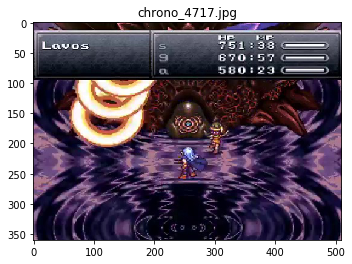

Dimensions: (510, 360) Total pixels: 183600


In [15]:
preview_random_image('training_set/chrono/')

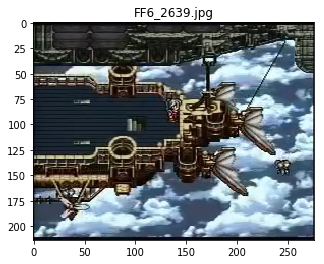

Dimensions: (276, 214) Total pixels: 59064


In [16]:
preview_random_image('training_set/FF6/')

On a side note I wonder why there is a difference when I rescale the image using openCV vs Keras. The openCV one looks closer to the initial one in my opinion...

In [ ]:
im = cv2.imread('training_set/chrono/chrono_1.jpg')
plt.imshow(im)

In [ ]:
# using openCV
im_cv = cv2.resize(im, (64, 64)) 
plt.imshow(im_cv)

In [ ]:
# using a function from Keras
im = load_img('training_set/chrono/chrono_1.jpg', target_size=(64, 64))
plt.imshow(im)

### Preparing training and test sets

Used data transformations:
* rescale - value by which the data will be multiplied before any other processing. Original images consists of RGB coefficients in 0-255 range. Such values can be too high for the model to process (with a typical learning rate), so multiplying by a factor of 1/255 will rescale the variable to range 0-1
* shear_range - for randomly applying shearing transformations
* zoom_range - for randomly zooming inside pictures
* horizontal_flip - for randomly flipping half of the images horizontally (relevant when there are no assumptions of horizontal assymetry e.g. real-world pictures)

Source: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html



In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (100, 100),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8000 images belonging to 3 classes.
Found 2000 images belonging to 2 classes.


In [93]:
# inspecting class labels for future reference 
labels_index = { 1 : "chrono", 0 : "FF6"}
training_set.class_indices

{'FF6': 0, 'chrono': 1, 'ipynb_checkpoints': 2}

### Preview the specified transformations

In [19]:
# I transform 20 images using the aforementioned transformations and store them in preview folder

files = os.listdir('training_set/chrono/')
img_name = files[randint(0, len(files) - 1)]
    
img = load_img('training_set/chrono/' + img_name)  

x = img_to_array(img)          
x = x.reshape((1,) + x.shape)  

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                                save_to_dir='preview', save_prefix='chrono', save_format='jpeg'):
    i += 1
    if i > 20:
        break  

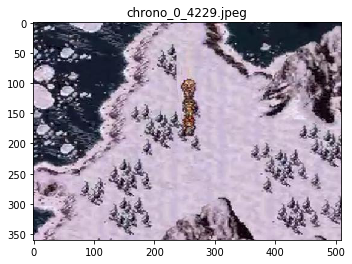

Dimensions: (510, 360) Total pixels: 183600


In [20]:
preview_random_image('preview/')

## Convolutional Neural Network approach ----

### Initialising CNN

In [21]:
# Initialising 
cnn_classifier = Sequential()

# 1st conv. layer
cnn_classifier.add(Conv2D(32, (3, 3), input_shape = (100, 100, 3), activation = 'relu'))
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd conv. layer
cnn_classifier.add(Conv2D(32, (3, 3), activation = 'relu')) #no need to specify the input shape
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 3nd conv. layer
cnn_classifier.add(Conv2D(64, (3, 3), activation = 'relu')) #no need to specify the input shape
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
cnn_classifier.add(Flatten())

# Full connection
cnn_classifier.add(Dense(units = 64, activation = 'relu'))
cnn_classifier.add(Dropout(0.2)) # quite aggresive dropout, maybe reduce
cnn_classifier.add(Dense(units = 1, activation = 'sigmoid'))

cnn_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
__________

Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

In [22]:
# Compiling the CNN
cnn_classifier.compile(optimizer = 'adam', # 'adam'/rmsprop'
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

### Fitting the model

In [23]:
cnn_classifier.fit_generator(training_set,
                             steps_per_epoch = 2000,
                             epochs = 1,
                             validation_data = test_set,
                             validation_steps = 2000)

Epoch 1/1
2000/2000 [==============================] - 1652s 826ms/step - loss: 0.1191 - acc: 0.9527 - val_loss: 0.0377 - val_acc: 0.9870


Tip from Keras blog:

Variance of the validation accuracy is fairly high, both because accuracy is a high-variance metric and because we only use 800 validation samples. A good validation strategy in such cases would be to do k-fold cross-validation, but this would require training k models for every evaluation round.

In [112]:
# saving model and weights 
cnn_classifier.save_weights('chrono_vs_FF6_model.h5')
cnn_classifier.save('chrono_vs_FF6_model.h5')

In [12]:
# load the model 
#
cnn_classifier = keras.models.load_model('chrono_vs_FF6_model.h5')

### Evaluating the results

In [100]:
#preparing data for predictions

size = (100, 100)
X_eval = list()
y_eval = list()

# chrono part
files = os.listdir('test_set/chrono')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/chrono/' + files[i + 1], size))
    y_eval.append(1)

# FF6 part
files = os.listdir('test_set/FF6')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/FF6/' + files[i + 1], size))
    y_eval.append(0)

# stacking the arrays   
X_eval = np.vstack(X_eval)
    

In [101]:
cnn_pred = cnn_classifier.predict_classes(X_eval, batch_size = 32)

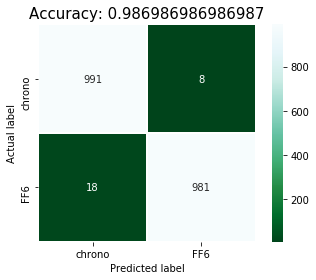

In [102]:
pretty_cm(cnn_pred, y_eval, ['chrono','FF6'])

### Explaining the results with LIME

In [103]:
correctly_classified_indices, misclassified_indices = evaluation_indices(cnn_pred, y_eval)

#### correctly classified images

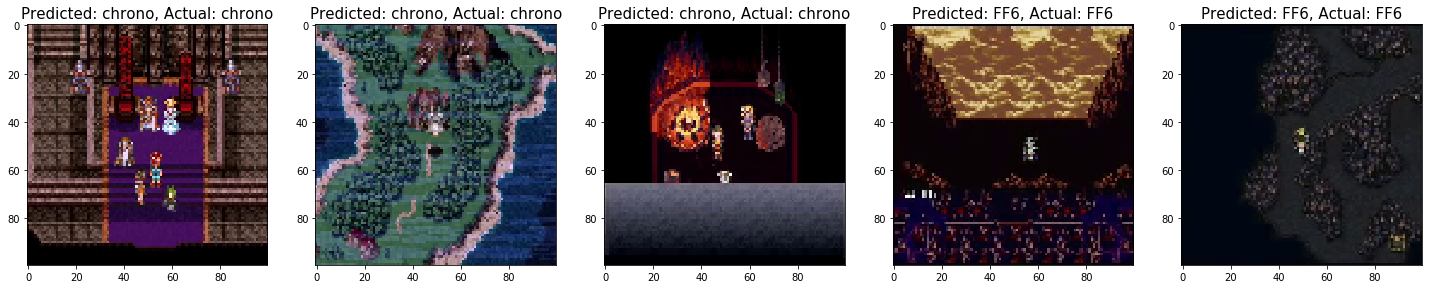

In [108]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[good_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)

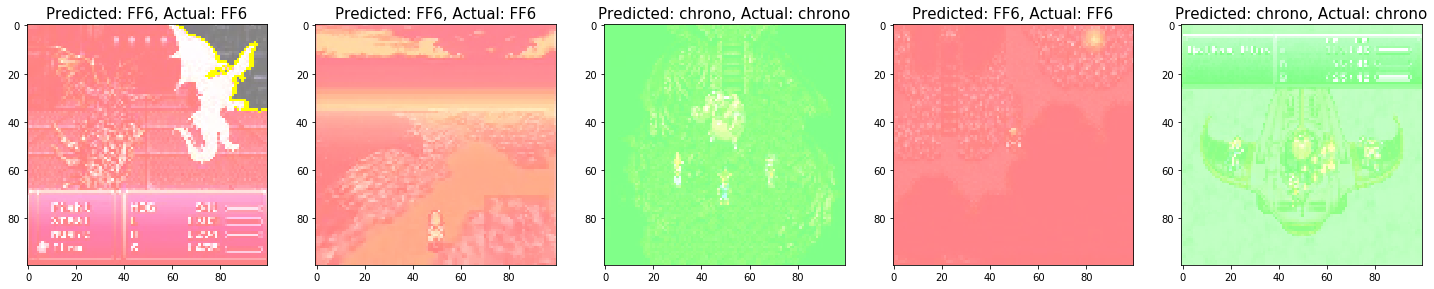

In [111]:
plt.figure(figsize=(25,5))
shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[good_index], cnn_classifier.predict_classes, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[good_index][0]], 
                                                 labels_index[y_eval[good_index]]), fontsize = 15)


#### misclassified images

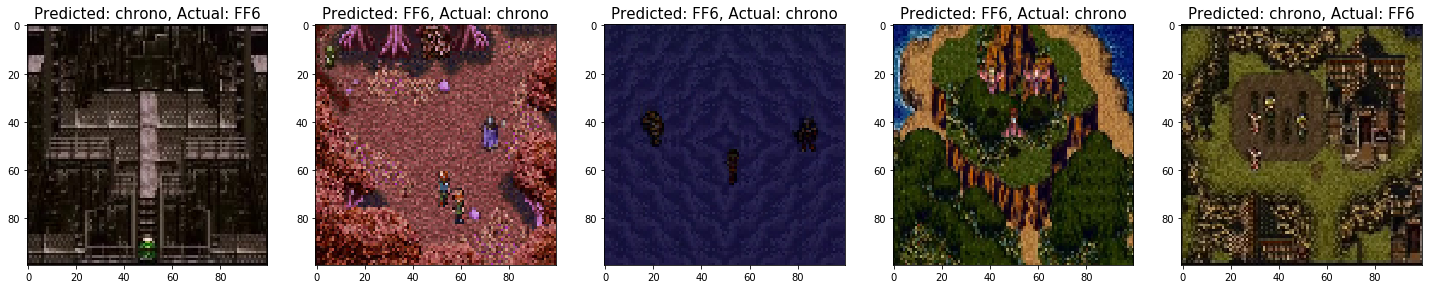

In [106]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(X_eval[bad_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)

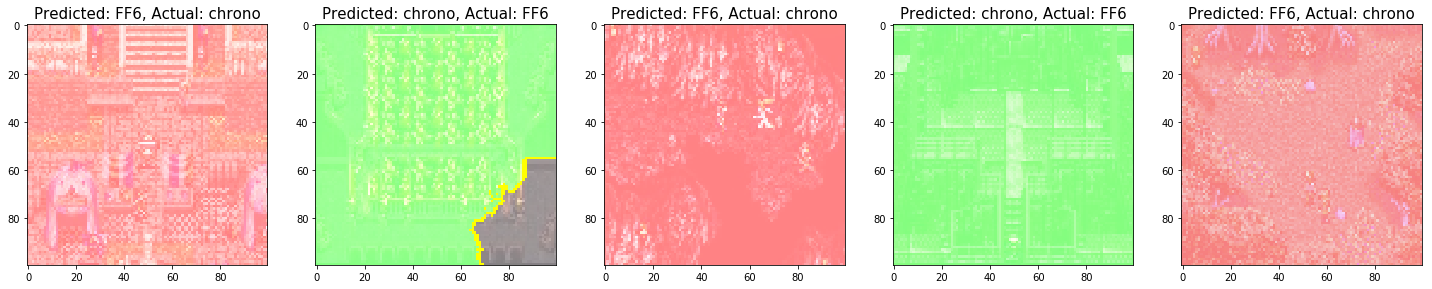

In [107]:
plt.figure(figsize=(25,5))
shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(X_eval[bad_index], cnn_classifier.predict_classes, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[cnn_pred[bad_index][0]], 
                                                 labels_index[y_eval[bad_index]]), fontsize = 15)
